# Overview

This is the third notebook of the project.

In this notebook, we will explor and anylyze data efficiency of supervised and unsupervised learning models, to see how they perform when the size of training data is limited.

# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# We only load train data for comparing

raw_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

# We shuffle it at the begining, so when we split we just select front x rows as traing, and rest as test
shuffled_df = raw_df.sample(frac=1, random_state=0)

print(shuffled_df.shape)

X = shuffled_df.values[:, 1:]
y = shuffled_df.values[:, 0]



(42000, 785)


# Method

We assume the scenario that we have 42k unlabeled images, and we are willing to spend time to manually label a limited number of randomly selected subset of the images. And then use those labled data to predict the label of the rest of the images.

We want to compare the performance with supervised learning and unsupervised learning in the way:

1. For supervised learning, we will use KNN and select the best k between 1 and 5

2. For unsupervised learning, we use T-SNE + GausianMixture, by selecting the n_clusters between 10 and 150. As long as the labels of the test set is not seen during training/prediction, we can use any value we want.



### Helper functions

To make the code concise, we first create some helper functions to be reused.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Helper function for evaluate the best accuracy using knn
def evl_knn(X_train, y_train, X_test, y_test):
    # split the train set to 80/20
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    best_validation_score = 0
    best_k = 0
    for k in range(1, 5):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_valid_pred = knn.predict(X_valid)
        score = accuracy_score(y_valid, y_valid_pred)
        print('k:', k, ', validation score:', score)
        if score > best_validation_score:
            best_validation_score = score
            best_k = k
    print('best k:', best_k, 'best_valid_score:', best_validation_score)
    
    # Calculate test score
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)
    return test_score





In [4]:
%%time

from sklearn.manifold import TSNE

# For unsupervised learning, we always use the full data set for clustering, so we just need to do tsne once.
# The difference in different train/test split, is only in using the label for
# 1. auto-mapping of cluster_id and true_label
# 2. parameter n_components selecting
# Helper function for evaluate the best accuracy using tsne + kmeans

tsne_2d = TSNE(n_components=2, random_state=99).fit_transform(X)



CPU times: user 22min 39s, sys: 3.27 s, total: 22min 42s
Wall time: 6min 50s


In [5]:
import plotly.express as px

def plot_2d(X_2d, y, model=''):
    df = pd.DataFrame(X_2d)
    df['label'] = y
    df.columns = ['x', 'y', 'label']
    # Converting label to string to get discrete colors in plot
    df['label'] = df['label'].astype(str)
    fig = px.scatter(df, x='x', y='y', color='label', hover_data=['label'])
    fig.update_layout(title = f'MNIST {model} 2D')
    fig.show()

In [6]:
from sklearn.mixture import GaussianMixture

# the gm results also only need to produced once, but will be used for different calculatings
gm_cluster_ids = []
for n_components in range(10, 140, 20):
    gmm = GaussianMixture(n_components, random_state=0)
    gm_cluster_ids.append(gmm.fit_predict(tsne_2d))
    

In [7]:
from scipy.stats import mode


# Helper function to get a map from cluster id to real label
# We utilize the true label to inffer the mapping
def cluster_id_2_label(cluster_ids, y_true):
    cluster_2_label = {}
    for i in np.unique(cluster_ids):
        #print('cluster id:', i)
        mask = (cluster_ids == i)
        y_mode = mode(y_true[mask])[0][0]
        cluster_2_label[i] = y_mode if y_mode is not None else -1

    return cluster_2_label

# helper class for evaluating gausian mixture
def evl_gm(X_train, y_train, X_test, y_test):
    best_train_score = 0
    best_y_all_predict = None
    for cluster_ids in gm_cluster_ids:
        cluster_id_map = cluster_id_2_label(cluster_ids[:y_train.shape[0]], y_train)
        try:
            # when the train size is too small and n_componetns is large, it can happen that there is no mapping found
            y_all_predict = np.vectorize(cluster_id_map.get)(cluster_ids)
        except:
            continue
        score = accuracy_score(y_train, y_all_predict[:y_train.shape[0]]) #only using train data for selection to be fair
        #print('gm score:', score)
        if score > best_train_score:
            best_train_score = score
            best_y_all_predict = y_all_predict
            
    # once we selected the best_cluster_ids, we calculate test score
    return accuracy_score(y_test, y_all_predict[y_train.shape[0]:])
           

In [12]:
# customized split, only separate the data without sampleing because it has been shuffled
def my_split(train_size):
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    return X_train, X_test, y_train, y_test

### Run tests

Now we are ready to run the tests with different size of labeled data.

In [9]:
train_sizes = [100*pow(2,n) for n in range(9)]
knn_scores = []
gm_scores = []
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = my_split(train_size)
    knn_score = evl_knn(X_train, y_train, X_test, y_test)
    knn_scores.append(knn_score)
    gm_score =  evl_gm(X_train, y_train, X_test, y_test)
    gm_scores.append(gm_score)
    print(f'train size: {train_size}, knn: {knn_score}, gm: {gm_score}')

k: 1 , validation score: 0.7
k: 2 , validation score: 0.6
k: 3 , validation score: 0.5
k: 4 , validation score: 0.65
best k: 1 best_valid_score: 0.7
train size: 100, knn: 0.6405011933174224, gm: 0.8673031026252983
k: 1 , validation score: 0.8
k: 2 , validation score: 0.825
k: 3 , validation score: 0.825
k: 4 , validation score: 0.875
best k: 4 best_valid_score: 0.875
train size: 200, knn: 0.7336842105263158, gm: 0.955287081339713
k: 1 , validation score: 0.8625
k: 2 , validation score: 0.8375
k: 3 , validation score: 0.85
k: 4 , validation score: 0.8375
best k: 1 best_valid_score: 0.8625
train size: 400, knn: 0.8244951923076923, gm: 0.9602884615384616
k: 1 , validation score: 0.86875
k: 2 , validation score: 0.85
k: 3 , validation score: 0.85625
k: 4 , validation score: 0.84375
best k: 1 best_valid_score: 0.86875
train size: 800, knn: 0.8630339805825242, gm: 0.9603398058252427
k: 1 , validation score: 0.89375
k: 2 , validation score: 0.878125
k: 3 , validation score: 0.9
k: 4 , validat

### Plot the results

Text(0, 0.5, 'accuracy')

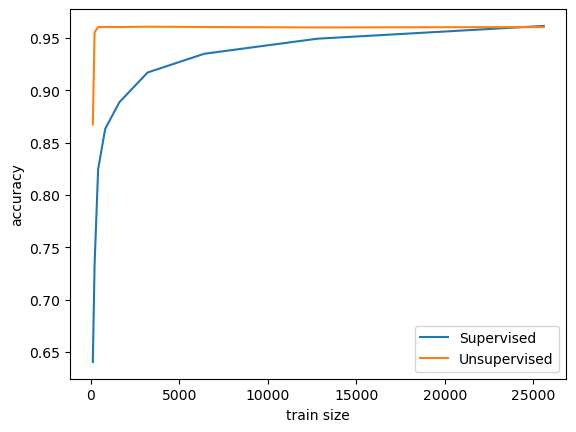

In [10]:
# plot the result

plt.plot(train_sizes,knn_scores, label='Supervised')
plt.plot(train_sizes,gm_scores, label='Unsupervised')
plt.legend(loc="lower right")
plt.xlabel('train size')
plt.ylabel('accuracy')

### Observations

1. As we can see, with 100 labeled data, unsupervised learning can achieve 87% accuracy, while supervised learning only 64%
2. Start from 200 labled data, the unsupervised learning keeps about 95%, 
3. Supervised learning only over perform it starts around 25k labeled data.


# Validate the conclusion

To validate if that is true in real case, I will do a experiementby:

1. Export a random set of 200 labeled data to a file in this notebook. 
2. Will create a new Notebook to import only those 200 labeled data.
3. Use those data to perform both supervised and unsupervised learning, to predict the label of the test data
4. Submit those test data to see if we can achieve 95% accruacy for unsupervised learning and 73% for supervised learning.


In [11]:
shuffled_df[:200].to_csv('mnist_200.csv', index=False)